# Introduction to Quant Finance

## Module 2.2: Modelling Techniques

### 2.2.3 ARCH and GARCH

Put simply, the ARCH model is the AR model, applied to the variance in residuals of a previously trained model. The GARCH model is the same analysis of the residuals a model, except using the ARMA model. Before we look at that, we first outline some of the key attributes that GARCH deals with.

**Heteroskedasticity** refers to the attribute of some variables to have a variance of residuals that varies wildly (almost everyone uses the term "wildly" here). It is indicative that there may be more factors that explain the way in which the data varies. *Homoskedastic* variables have a consistent variance, a key component, but not a sufficient one for stationarity (for instance, the variance may be constant, but there may be a trend in the mean).

A **conditional heteroskedastic** variable is one that has a conditional component. For instance, if the market drops, it might go into panic, causing further drops. This drop was conditional on the previous drop.

We now have the necessary components to understand the ARCH and GARCH models:

* ARCH stands for Autoregressive Conditionally Heteroskedastic
* GARCH stands for Generalized Autoregressive Conditionally Heteroskedastic 

We apply ARCH and GARCH models *after* we have fitted a model to the original dataset. Importantly, the residuals after fitting that first model should look like it is discrete noise. The ARCH modelling then looks for a pattern in the residuals of that model, specifically at a given lag. It is this variance over time that autoregressive models cannot model.


### ARCH Models

The ARCH(1) model is given by:

$ Var(y_t) = \alpha_0 + \alpha_1 y_{t-1}^2$


Which is the AR model, but on variance instaed of raw values.

The GARCH(1,1) model is 

$Var(y_t) = \alpha_0 + \alpha_1 y_{t-1}^2  + \alpha_2 Var(y_{t-1})$

Which you'll notice is the ARMA model applied to the variance rather than the absolute value. The model is stable only if the sum of all $\alpha_i$ values is less than 1. 

Generalisations, such as GARCH(2, 2) are also possible by adding further lagged terms to each of the AR and MA components of the equation, in the same manner they can, for instance, be added to ARIMA.

We'll generate some data that fits this model, and the shown the residual graph and autocorrelations, highlighting what a dataset that fits ARCH/GARCH looks like.

In [1]:
%run setup.ipy

In [2]:
y = np.zeros(1000)

In [3]:
y[0] = np.random.normal()
for i in range(1, len(y)):
    y[i] = np.random.normal() * np.sqrt(5 + 0.75 * y[i-1]**2)

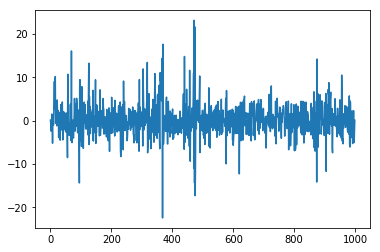

In [4]:
plt.plot(y)

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

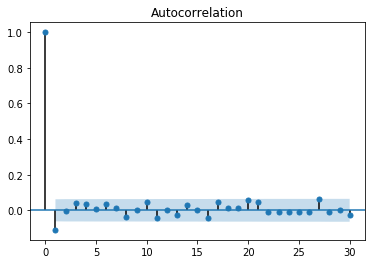

In [6]:
plot_acf(y, lags=30);

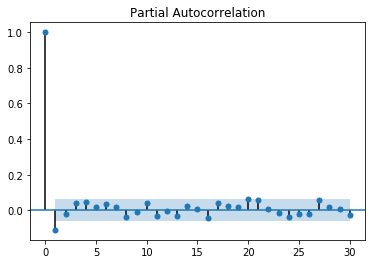

In [7]:
plot_pacf(y, lags=30);

Notice there isn't really much by the way of autocorrelation in y - it looks like white noise. This mimics the residuals *after* fitting a good model to the original data.

However, you might suspect a problem with a variance dependent on time. To test this, first we test the same correlation, but on the squared residuals:

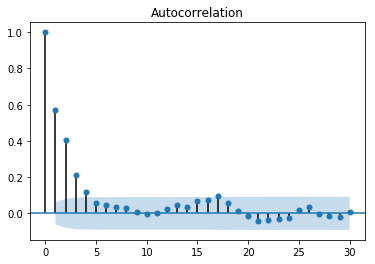

In [8]:
plot_acf(y**2, lags=30);

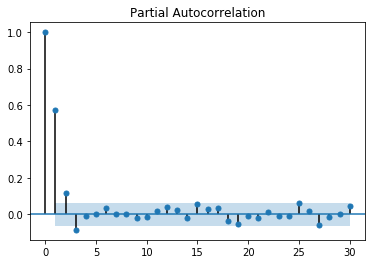

In [9]:
plot_pacf(y**2, lags=30);

Here you see a strong lagged autocorrelation at lag 1. If you see this result (for any reasonable lag), it is time to fit an ARCH model.

There is a useful arch model in the `arch` package

In [ ]:
!pip install arch

In [11]:
from arch import arch_model

In [12]:
model = arch_model(y)

In [13]:
results = model.fit()  # As per statsmodels

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2657.206973327898
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2652.273276598221
Iteration:      3,   Func. Count:     21,   Neg. LLF: 2633.407531655701
Iteration:      4,   Func. Count:     28,   Neg. LLF: 2626.4128383255966
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2615.8438103381386
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2587.8342952351472
Iteration:      7,   Func. Count:     48,   Neg. LLF: 2583.052914134524
Iteration:      8,   Func. Count:     55,   Neg. LLF: 2582.965592784246
Iteration:      9,   Func. Count:     61,   Neg. LLF: 2582.9306732905325
Iteration:     10,   Func. Count:     67,   Neg. LLF: 2582.92346328225
Iteration:     11,   Func. Count:     73,   Neg. LLF: 2582.9227087477375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2582.9227082947878
            Iterations: 11
            Function evaluations: 73
            Gradient evaluatio

In [13]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2599.71
Distribution:                  Normal   AIC:                           5207.42
Method:            Maximum Likelihood   BIC:                           5227.05
                                        No. Observations:                 1000
Date:                Thu, Mar 28 2019   Df Residuals:                      996
Time:                        06:51:42   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1630  7.251e-02      2.248  2.460e-02 [2.086e-02,  0.305]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          4.4763      0.433     10.349  4.223e-25      [  3.629,  5.324]
alpha[1]       0.8397  7.745e-02     10.843  2.159e-27      [  0.688,  0.992]
beta[1]    7.2758e-03  1.636e-02      0.445      0.657 [-2.479e-02,3.934e-02]
=============================================================================

Covariance estimator: robust
"""

We can then use the ARCH model to predict the next values, by taking the fitted model and asking it to forecast into the future. This is the predicted variance of the next value in the series.

In [24]:
# Get the last prediction when forcasting into the future. 
# This weird function call just gets us the "next" prediction.
# The actual forecast result has lots more information
prediction = results.forecast(horizon=1, start=None).mean.iloc[-1]['h.1']
prediction

0.1629690140190518

From here, you can see the values for alpha are non-zero, based on the p test and beta are approximately zero. Further, there is the omega value that is 4.7 (we used 5 for generating the data) above.

#### Exercise

1. Map the coefficients in the volatility results summary above to the model for GARCH above. Check the documentation for the function if needed.
2. Modify the code we used to *create* the data, adding a second lag term. Fit the GARCH(1,1) model again, and see what the results look like when the model does not have enough specificity. Then fit a GARCH(2,2) model and observe the improvement.

#### Extended exercise Combining the steps

We'll now combine the steps we have covered, specifically ARIMA and GARCH, to fit a model to predict the price of the market. While this is an exercise here, a template for this code, with some parts missing, is available at:

`solutions/arima_garch_prediction_template.py`

If you get stuck, feel free to start with this template and fill out the details. If you are more confident, try solving the exercise without it.

The general process for using ARIMA and GARCH together for forecasting is to:

1. Download data, such as from Quandl, for the asset you are predicting
1. Compute the log returns for each day
1. For each day in your dataset:
    1. Fit multiple ARIMA models on the data *up to that day* and choose the best one (or use an automatic choice)
    1. Fit a GARCH model to the residuals of the ARIMA model
    1. Use the fitted GARCH model to predict the next step
    1. If positive, buy. If negative, sell
3. Backtest strategy and compare against the market gain over that time (i.e. just buying and holding).

More information: https://arch.readthedocs.io/en/latest/univariate/introduction.html